# Harmonic Oscillator Equation

We consider the harmonic oscillator without driving term (F=0), the corresponding second order ode is:

$$

\frac{d^2x}{dt^2} + \delta\frac{dx}{dt} + \omega^2x = 0, \qquad \text{where} \quad  t \in [0,10],

$$

with the initial conditions:

\begin{align}

x(0) = 2, \\

\left. \frac{dx}{dt} \right|_{t=0} = 0.

\end{align}

The reference solution is generated using *integrate.solve_ivp()* from *SciPy*.

## Implementation and Training

First, we import the Torch, NumPy, Matplotlib, DateTime, Math and SciPy libraries:

In [11]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import datetime
import math
from scipy.integrate import solve_ivp

Now, we set the values of $\omega$ and $\delta$ parameters and the $t$ domain with 100 points: 

In [ ]:
omega = math.pi
delta = .5

t_max = 10.

t = np.linspace(0, t_max, 100)

We solve the ODE using the SciPy module by transforming the second-order equation into a first-order system; in other words, we introduce the velocity ($v = \frac{dx}{dt}$). In addition, we plot the solution:

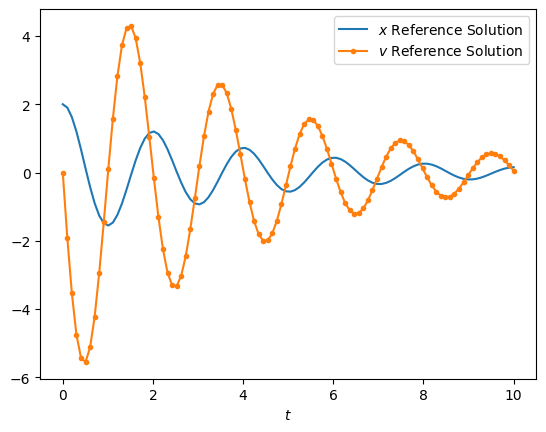

In [ ]:
def x(t, y, omega, delta):
    x = y[0]
    v = y[1]

    dxdt = v
    dvdt = -delta*v - x*omega**2
    return np.array([dxdt, dvdt])

x0 = 2.0           #initial condition for x
v0 = 0.0           #initial condition for v
IC = (x0,v0)

integrator = "RK23"

ref_sol = solve_ivp(x, (t[0], t[-1]), IC, t_eval= t, args=(omega, delta), method = integrator)

xsol = ref_sol.y[0]

vsol = ref_sol.y[1]

plt.figure()
plt.plot(t, xsol, '-', label='$x$ Reference Solution')
plt.plot(t, vsol, '.-', label='$v$ Reference Solution')
plt.xlabel('$t$')
plt.legend()


Now, we set the parameters of the neural network: it has a structure with 1 input ($t$) and 1 output ($x(t)$), 10000 maximum training steps, 2 hidden layers with 32 neurons each, 100 samples and a target minimum loss value of $10^{-3}$.

In [14]:
inputs = 1
outputs = 1
hn_1 = 32
hn_2 = 32
steps = 0
max_steps = 10000
loss = 10
min_loss = 1e-3
log_each = 500
samples = 100
loss_values = []

In this part, we define a new class implementing the activation function $sin(x)$, due to the oscillatory nature of the solution.

In [15]:
class Sine(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return torch.sin(x)

The multilayer perceptron (MLP) structure is:

In [16]:
mlp = nn.Sequential(
    nn.Linear(inputs,hn_1),
    Sine(),
    nn.Linear(hn_1, hn_2),
    Sine(),
    nn.Linear(hn_2, outputs)
)

optimizer = torch.optim.Adam(mlp.parameters())
criterion = nn.MSELoss()
mlp.train()

Sequential(
  (0): Linear(in_features=1, out_features=32, bias=True)
  (1): Sine()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): Sine()
  (4): Linear(in_features=32, out_features=1, bias=True)
)

In this section, we define a function that calculates the gradients.

In [17]:

def computeGrads(y, x):
    grads, = torch.autograd.grad(y, x, grad_outputs=y.data.new(y.shape).fill_(1), create_graph=True, only_inputs=True)
    return grads

Next, we define the main training loop and the timer:

In [ ]:
starttime_train = datetime.datetime.now()
print('----Training Started----')

while steps < max_steps and loss > min_loss:
    X = (t_max - 0)*torch.rand((samples, 1), requires_grad=True)
    Y = mlp(X)
    dxdt = computeGrads(Y, X)
    d2xdt2 = computeGrads(dxdt, X)
    ode_loss = criterion(d2xdt2, -delta*dxdt - (omega**2)*Y)

    #initial condition for x(0) = 0
    X0 = torch.zeros(samples, 1)
    Y0 = mlp(X0)
    x2 = 2*torch.ones(samples, 1)
    ic1_loss = criterion(Y0, x2)

    #initial condition for dxdt|t=0 = 0
    X0 = torch.zeros((samples, 1), requires_grad=True)
    Y0 = mlp(X0)
    dxdt0 = computeGrads(Y0, X0)
    zero = torch.zeros(samples, 1)
    ic2_loss = criterion(dxdt0, zero)

    optimizer.zero_grad()
    loss = ode_loss + ic1_loss + ic2_loss
    loss.backward()
    optimizer.step()

    loss_values.append(loss.detach().numpy())

    if steps % log_each == 0:
        print(f'Step:{steps}| ode_loss {ode_loss.item():.5f} ic1_loss {ic1_loss.item():.5f} ic2_loss {ic2_loss.item():.5f}')

    steps+=1

endtime_train = datetime.datetime.now()
train_time = endtime_train - starttime_train
train_time_formatted = train_time.seconds + train_time.microseconds / 1e6
print('---Training Finished---')

print(f'Training Duration: {steps} steps in {train_time_formatted:.3f} seconds')

----Training Started----
Step:0| ode_loss 11.63269 ic1_loss 5.00832 ic2_loss 0.19554
Step:500| ode_loss 0.74390 ic1_loss 1.29422 ic2_loss 0.00521
Step:1000| ode_loss 0.52648 ic1_loss 0.48685 ic2_loss 0.00014
Step:1500| ode_loss 0.22569 ic1_loss 0.12726 ic2_loss 0.00009
Step:2000| ode_loss 0.03604 ic1_loss 0.00166 ic2_loss 0.00000
Step:2500| ode_loss 0.02187 ic1_loss 0.00127 ic2_loss 0.00007
Step:3000| ode_loss 0.01013 ic1_loss 0.00011 ic2_loss 0.00008
Step:3500| ode_loss 0.00426 ic1_loss 0.00001 ic2_loss 0.00003
Step:4000| ode_loss 0.00264 ic1_loss 0.00003 ic2_loss 0.00001
---Training Finished---
Training Duration: 4379 steps in 8.509 seconds


## Visualization

To visualize the model and compare results, we obtain the output of the trained model.

In [19]:
with torch.no_grad():
    X = torch.stack([torch.from_numpy(t).float()], axis=-1)
    Y = mlp(X)

result = Y.detach().numpy()

Finally, we plot the exact solution with the PINN approximation:

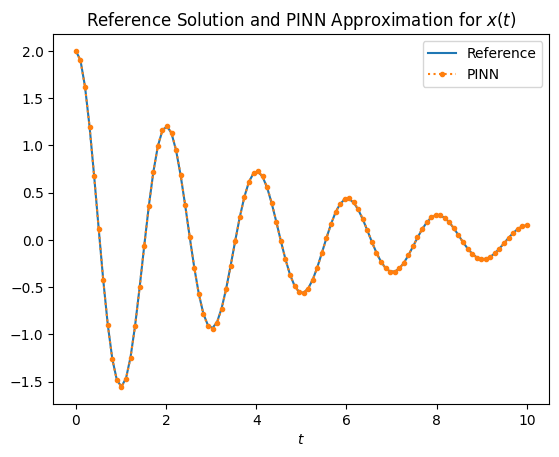

In [20]:
plt.figure()
plt.plot(t, xsol, '-', label = 'Reference')
plt.plot(t, result, '.:', label = 'PINN')
plt.title('Reference Solution and PINN Approximation for $x(t)$')
plt.xlabel('$t$')
plt.legend()